# **Exploratory data analysis for TUNINDEX**

In [3]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error



In [4]:
df_all = pd.read_csv('../data/clean/TUNINDEX_data.csv', index_col='date', parse_dates=['date'])

In [5]:
# Sort dataframe from oldest to newest
df_all = df_all.sort_index()
df_all['returns'] = (df_all['close'].pct_change())
df_all.dropna(inplace=True)

In [6]:
df_all.head()

,close,open,high,low,returns
date,,,,,
2014-01-03,4384.90,4413.84,4426.51,4384.90,-0.006109
2014-01-06,4361.62,4364.39,4378.92,4346.90,-0.005309
2014-01-07,4343.16,4360.33,4377.12,4337.29,-0.004232
2014-01-08,4344.26,4344.43,4348.97,4319.56,0.000253
2014-01-09,4339.18,4351.85,4351.89,4323.37,-0.001169


In [7]:
df_all.tail()

,close,open,high,low,returns
date,,,,,
2024-09-02,9784.10,9810.38,9813.40,9769.79,-0.002679
2024-09-03,9804.93,9783.83,9810.03,9766.08,0.002129
2024-09-04,9800.84,9805.00,9814.83,9761.67,-0.000417
2024-09-05,9810.67,9800.26,9830.59,9777.23,0.001003
2024-09-06,9804.44,9810.67,9810.98,9771.62,-0.000635


In [8]:
df_all.describe()

,close,open,high,low,returns
count,2673.000000,2673.00000,2673.000000,2673.000000,2673.000000
mean,6740.175129,6740.21284,6758.233868,6716.308545,0.000308
std,1313.268336,1312.33163,1316.258484,1307.973261,0.004302
min,4339.180000,4338.92000,4348.970000,4319.560000,-0.040995
25%,5526.820000,5527.20000,5536.530000,5511.010000,-0.001812
50%,6913.640000,6915.45000,6933.420000,6882.400000,0.000225
75%,7426.180000,7420.38000,7450.850000,7391.030000,0.002493
max,9875.030000,9875.03000,9886.200000,9837.760000,0.027139


## ***How much data to use ?***

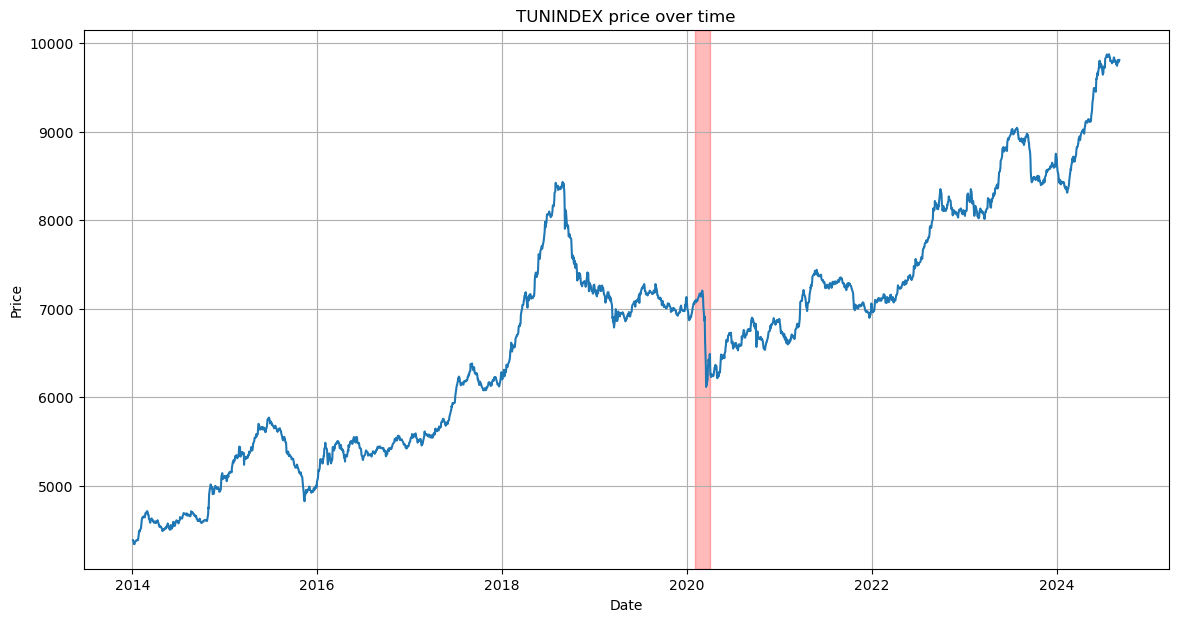

In [9]:
# ploting TUNINDEX price over time
plt.figure(figsize=(14, 7))
plt.plot(df_all['close'])
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('TUNINDEX price over time')
plt.axvspan('2020-02-01', '2020-04-01', color='red', alpha=0.27)
plt.grid(True)
plt.show()



### ***Decision***
As shown in the graph by the red band there is sudden drop coinciding with the Covid period, which could introduce noise into the model. Given that the forecasting goal is short-term, I've decided to:
- **Exclude data from the Covid drop period**
- **Focus exclusively on post-Covid drop data**

In [11]:
covid_start_date = pd.to_datetime('2020-04-01')
df = df_all[df_all.index >= covid_start_date]

### ***How to impute missed days ?***

In [13]:
# Find all business days from the start to the last and find missing dates
all_dates = pd.date_range(start=df.index.min(), end=df.index.max(), freq='B')
df_full = df.reindex(all_dates)
missing_dates = df_full[df_full.isna().any(axis=1)].index

# Create a list that contains the month and day of the missing dates
month_day = [(date.month,date.day) for date in missing_dates]
# Dictionary that shows the date and it's count
date_counts = {}
for date in month_day:
    if date in date_counts:
        date_counts[date] +=1
    else:
        date_counts[date] =1
print(f'Total number of missing days: {len(missing_dates)}.\nUnique number of missing days: {len(date_counts)}.')

Total number of missing days: 42.
Unique number of missing days: 30.


### ***Decision***
Since most of the dates coincide with national holidays and  imputing these values using the last available day could potentially disrupt the accuracy of the GARCH model, I've decided to:
- **Retain the data as is**

## **Time Series Analysis**
- Trend Analysis 

In [16]:
covid_start_date = pd.to_datetime('2020-04-01')
df = df_all[df_all.index >= covid_start_date]


C:\Users\azizb\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


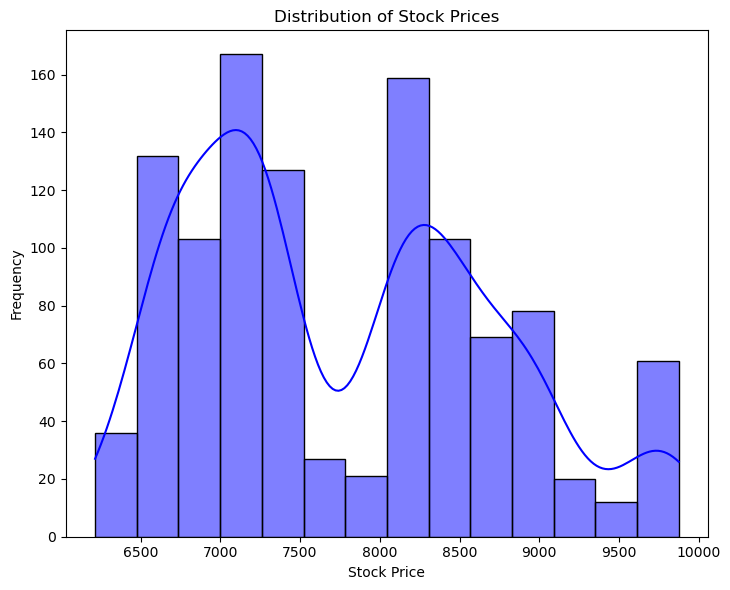

In [17]:
plt.figure(figsize=(14, 6))

# Histogram of stock prices
plt.subplot(1, 2, 1)
sns.histplot(df['close'], kde=True, color='blue')
plt.title('Distribution of Stock Prices')
plt.xlabel('Stock Price')
plt.ylabel('Frequency')



plt.tight_layout()
plt.show()

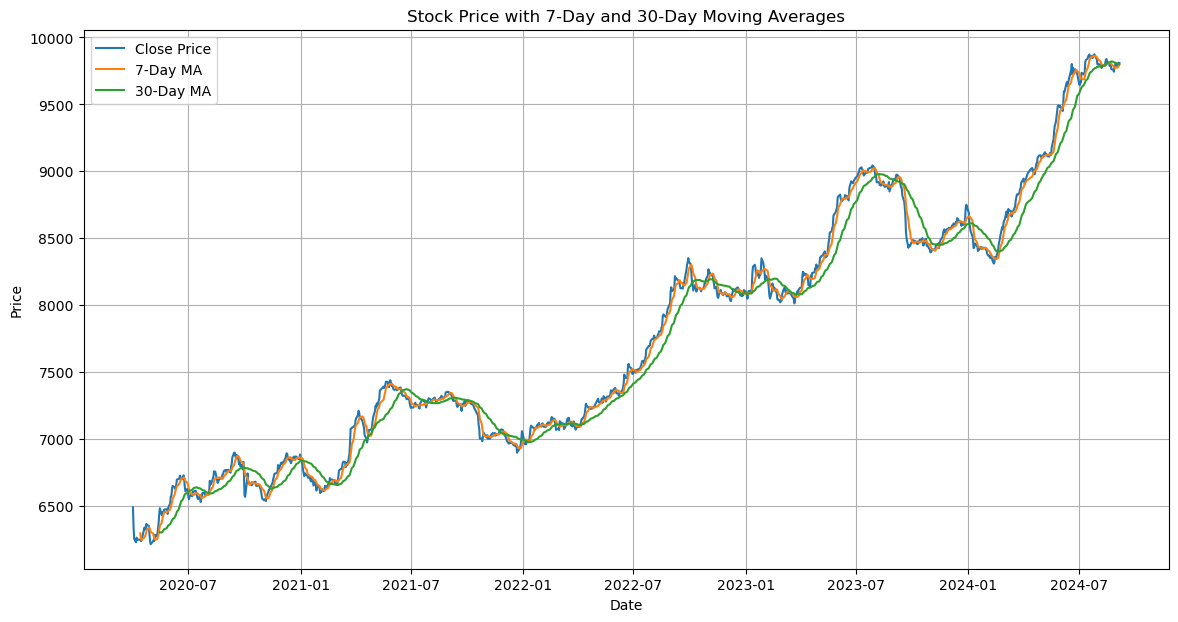

In [18]:
MA_7 = df['close'].rolling(window=7).mean()
MA_30= df['close'].rolling(window=30).mean()

# Plot Moving Averages
plt.figure(figsize=(14, 7))
plt.plot(df['close'], label='Close Price')
plt.plot(MA_7, label='7-Day MA')
plt.plot(MA_30, label='30-Day MA')
plt.title('Stock Price with 7-Day and 30-Day Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True)
plt.legend()
plt.show()

### ***Checking for ARIMA model assumptions:***
- **Stationarity**

In [20]:
result = adfuller(df['close'])

# Extract and display test results
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:')

# Interpretation
if result[1] > 0.05:
    print("The series is non-stationary (fail to reject the null hypothesis).")
else:
    print("The series is stationary (reject the null hypothesis).")

ADF Statistic: -0.045687970450190886
p-value: 0.9545866452400934
Critical Values:
The series is non-stationary (fail to reject the null hypothesis).


In [21]:
# Since data is non-stationary: therefore I will apply first differencing
df['first_differencing'] = df['close'].diff()
df = df.dropna()


C:\Users\azizb\AppData\Local\Temp\ipykernel_107264\704520559.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['first_differencing'] = df['close'].diff()


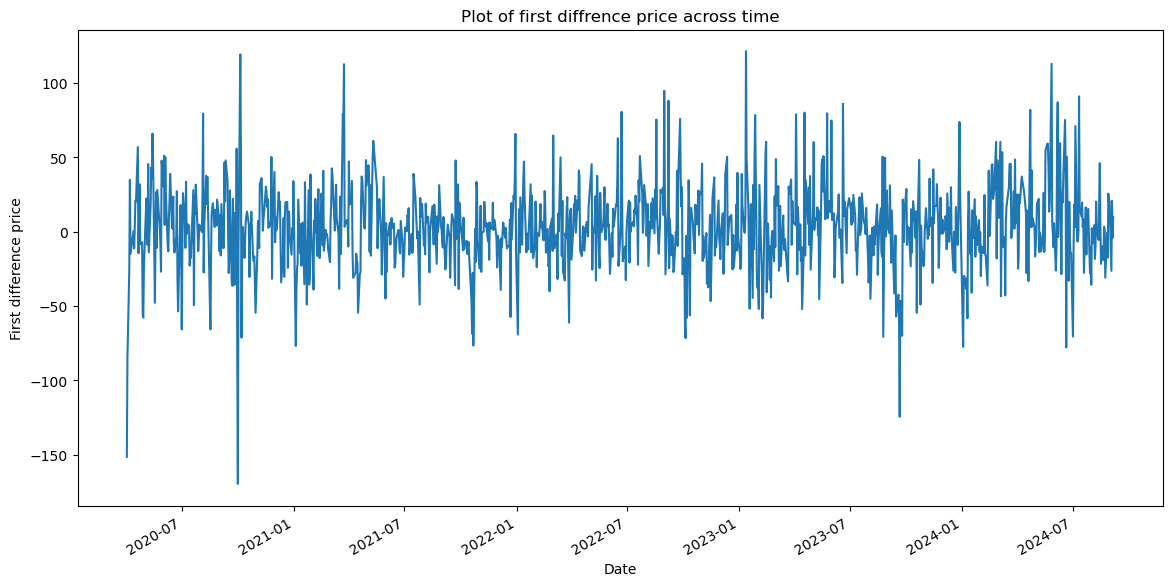

In [22]:
plt.figure(figsize=(14, 7))
df['first_differencing'].plot()
plt.xlabel('Date')
plt.ylabel('First difference price')
plt.title('Plot of first diffrence price across time');

In [23]:
result = adfuller(df['first_differencing'])

# Extract and display test results
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:')

# Interpretation
if result[1] > 0.05:
    print("The series is non-stationary (fail to reject the null hypothesis).")
else:
    print("The series is stationary (reject the null hypothesis).")

ADF Statistic: -12.480147070234993
p-value: 3.104465700311629e-23
Critical Values:
The series is stationary (reject the null hypothesis).


### ***Decision***

Using the graph and the Augmented Dickey–Fuller test we can notice that the stock price is not stationary.Therefore i've applied first-order differencing to make data stationary which means for ARIMA model d = 1


- **No Seasonality**


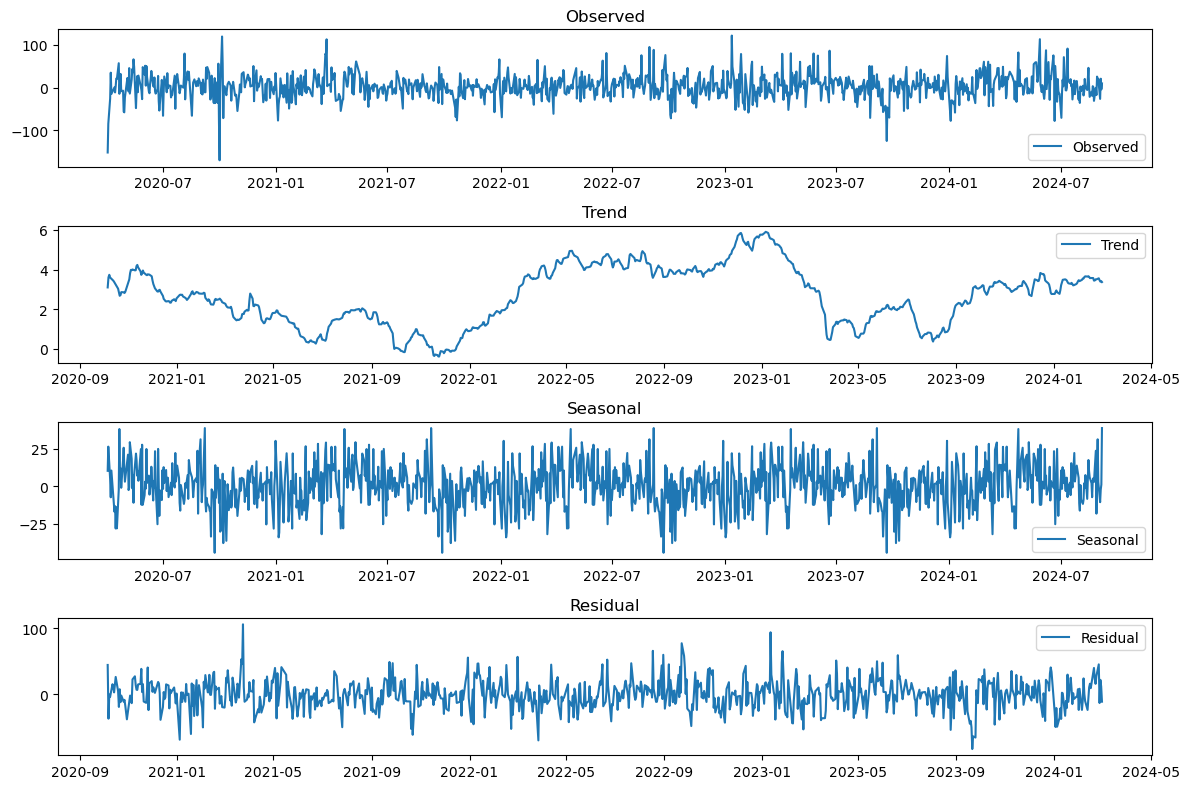

In [26]:
# Decompose the time series
decomposition = seasonal_decompose(df['first_differencing'], model='additive', period=252) # used additive model Y(t)=T(t)+S(t)+R(t)

# Plot the decomposed components
plt.figure(figsize=(12, 8))

plt.subplot(4, 1, 1)
plt.plot(decomposition.observed, label='Observed')
plt.title('Observed')
plt.legend()

plt.subplot(4, 1, 2)
plt.plot(decomposition.trend, label='Trend')
plt.title('Trend')
plt.legend()

plt.subplot(4, 1, 3)
plt.plot(decomposition.seasonal, label='Seasonal')
plt.title('Seasonal')
plt.legend()

plt.subplot(4, 1, 4)
plt.plot(decomposition.resid, label='Residual')
plt.title('Residual')
plt.legend()

plt.tight_layout()
plt.show()


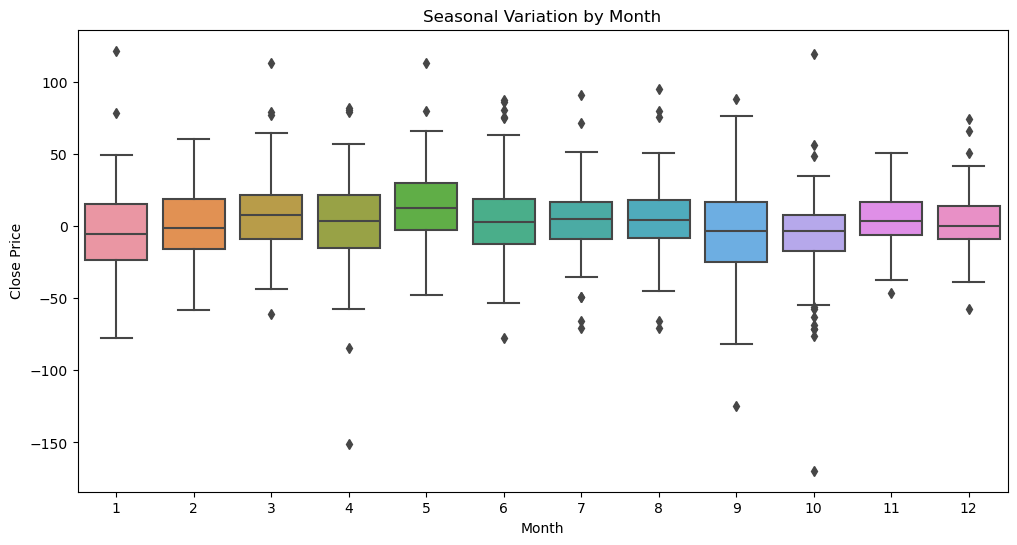

In [27]:
# Add a month column for seasonal analysis
Month = df.index.month

# Plot seasonal trends by month
plt.figure(figsize=(12, 6))
sns.boxplot(x=Month, y='first_differencing', data=df)
plt.title('Seasonal Variation by Month')
plt.xlabel('Month')
plt.ylabel('Close Price')
plt.show()


### ***Decision***

Based on the seasonal decomposition of the time series and the boxplot, it appears that while there is some degree of seasonality,However it seems negligible
- **Decide to go with ARIMA model**


### ARIMA model paramaters selection

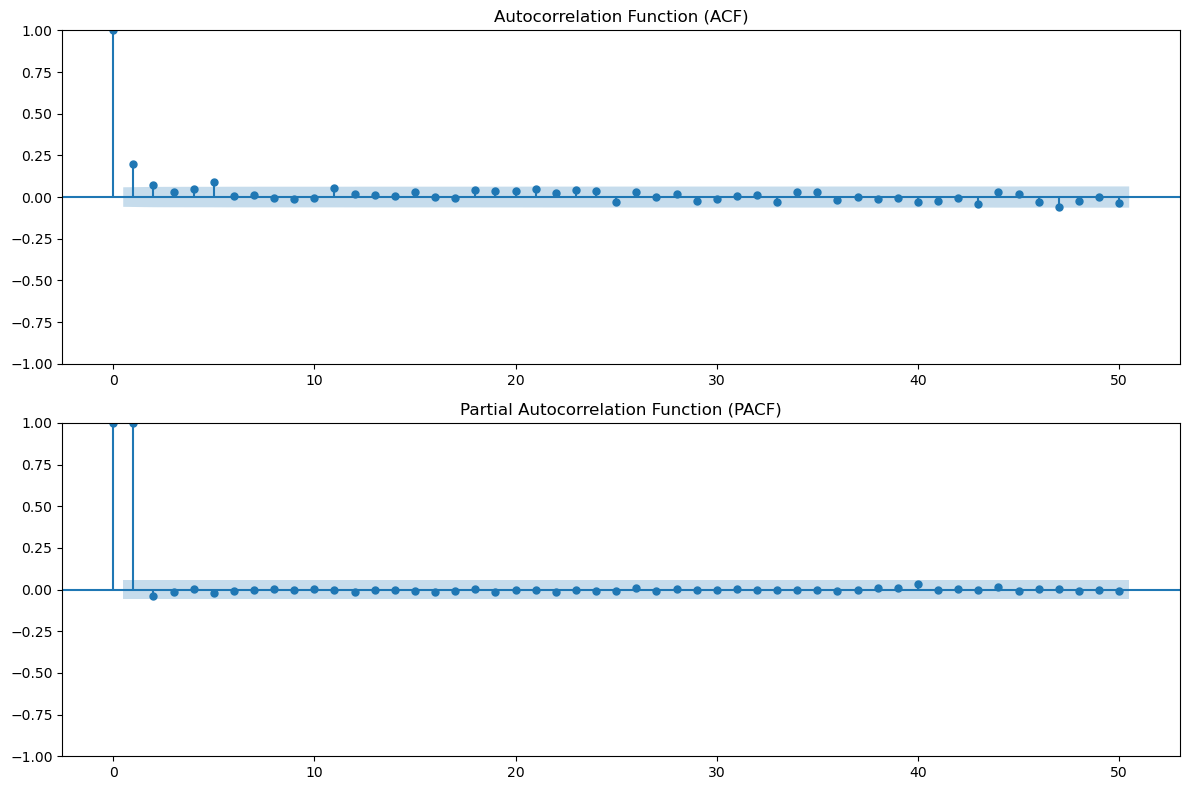

In [30]:
# Plot ACF and PACF
plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
plot_acf(df['first_differencing'], lags=50, ax=plt.gca())
plt.title('Autocorrelation Function (ACF)')

plt.subplot(2, 1, 2)
plot_pacf(df['close'], lags=50, ax=plt.gca())
plt.title('Partial Autocorrelation Function (PACF)')

plt.tight_layout()
plt.show()

### ***Decision***
model paramaters (1,1,1),(1,1,2),(1,1,5)

In [32]:
#Save training data for arima model 
df['close'].to_csv('../data/clean/training_arima.csv',index=True)
df['returns'].to_csv('../data/clean/training_garch.csv',index=True)

# **ARIMA Model Building**

In [34]:
y = df['close']

In [35]:
y.head()

date
2020-04-02    6337.93
2020-04-03    6253.63
2020-04-06    6227.91
2020-04-07    6262.81
2020-04-08    6247.93
Name: close, dtype: float64

In [36]:
y.tail()

date
2024-08-30    9810.38
2024-09-02    9784.10
2024-09-03    9804.93
2024-09-04    9800.84
2024-09-05    9810.67
Name: close, dtype: float64

In [37]:
y.info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 1114 entries, 2020-04-02 to 2024-09-05
Series name: close
Non-Null Count  Dtype  
--------------  -----  
1114 non-null   float64
dtypes: float64(1)
memory usage: 17.4 KB


In [38]:
cutoff = int(len(y)*0.8) 
y_train = y.iloc[:cutoff]

# Baseline model ma(3)
window  = 3
y_pred_baseline = y.rolling(window = window).mean().shift(1)
mse_pred = mean_squared_error(y[cutoff:], y_pred_baseline[cutoff:])
print(f'Mean Squared Error of the baseline Model: {mse_pred}')

Mean Squared Error of the baseline Model: 1731.2505947184861


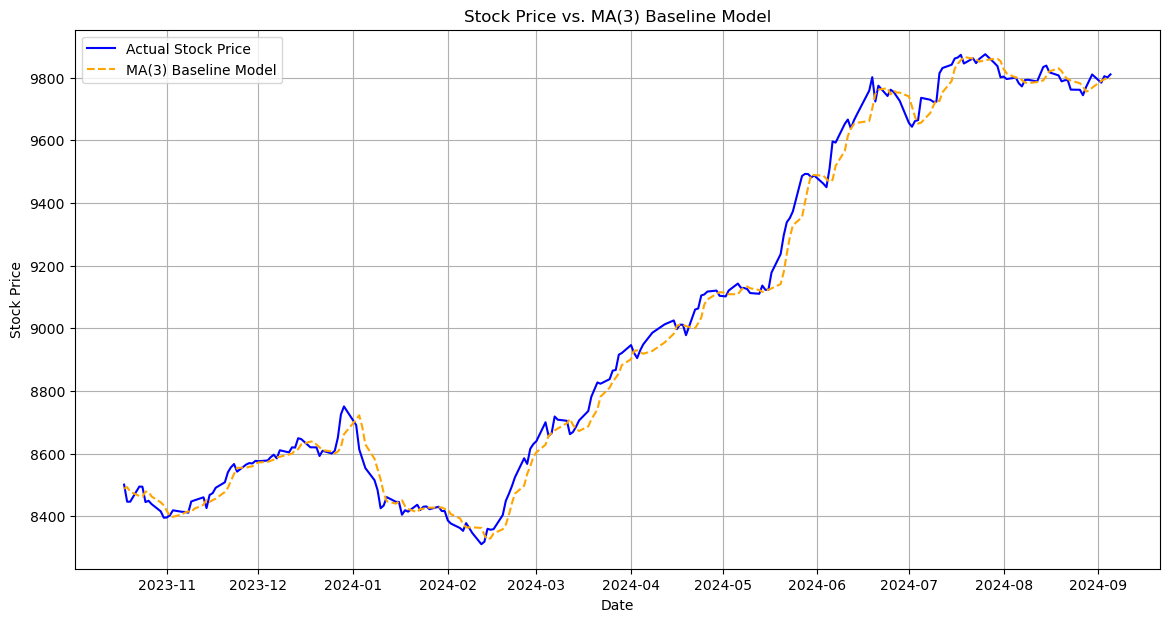

In [39]:
actual = y[cutoff:]
plt.figure(figsize=(14, 7))
plt.plot(y[cutoff:], label='Actual Stock Price', color='blue')

# Plot the Baseline predictions
plt.plot(actual.index, y_pred_baseline[cutoff:], label='MA(3) Baseline Model', color='orange', linestyle='--')

# Adding labels and title
plt.title('Stock Price vs. MA(3) Baseline Model')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)

# Display the plot
plt.show()

### **Chossing best model paramaters**

In [41]:
models = [(1, 1, 1), (1, 1, 2), (1, 1, 5)]
results = []
for order in models:
    history = list(y_train)
    predictions = []
    
    for i in range(cutoff,len(y)):
        model = ARIMA(history,order=order).fit()
        yhat = model.forecast()[0]
        predictions.append(yhat)
        history.append(y.iloc[i])
        
    mse = mean_squared_error(y[cutoff:],predictions)
    results.append((order,mse))
results_df = pd.DataFrame(results, columns=['Order', 'MSE'])

# Sort by MSE to find the best model
best_model = results_df.sort_values('MSE').iloc[0]
best_model

C:\Users\azizb\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


Order     (1, 1, 2)
MSE      849.316177
Name: 1, dtype: object

## ***Decision*** 
Since paramaters (1,1,2) have the lowest MSE 
- I chose (1,1,2)

In [43]:
# Retrieve the predictions from the best model based on MSE
best_order = best_model['Order']
history = list(y_train)
predictions = pd.Series(dtype=float) 

for i in range(cutoff, len(y)):
    model = ARIMA(history, order=best_order).fit()
    yhat = model.forecast()[0]
    predictions.loc[y.index[i]] = yhat
    history.append(y.iloc[i])



C:\Users\azizb\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


## *Assumptions of ARIMA*
- **White noise and normality**

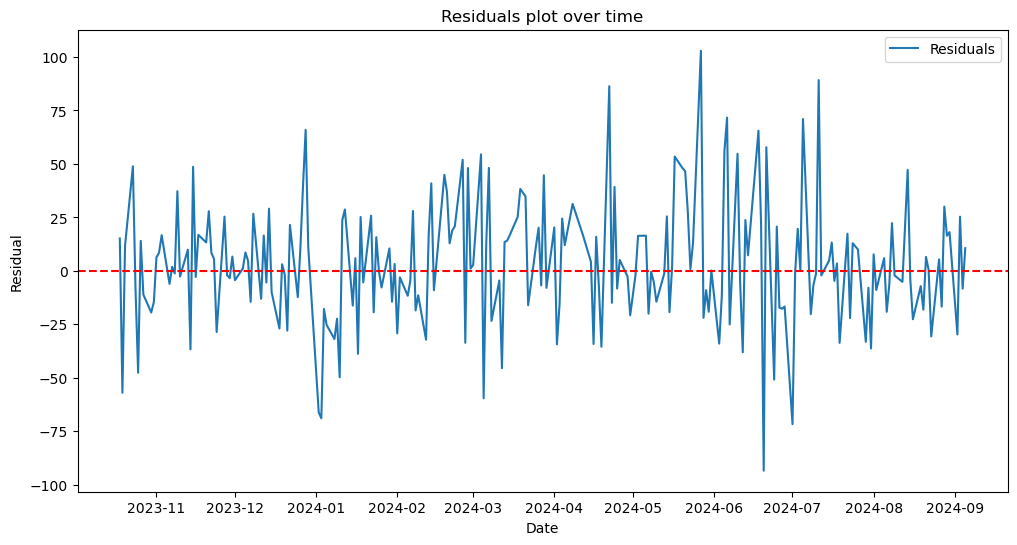

In [45]:
residuals = actual - predictions 

# Line plot of residuals
plt.figure(figsize=(12, 6))
plt.plot(residuals, label='Residuals')
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residuals plot over time')
plt.xlabel('Date')
plt.ylabel('Residual')
plt.legend()
plt.show()



C:\Users\azizb\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


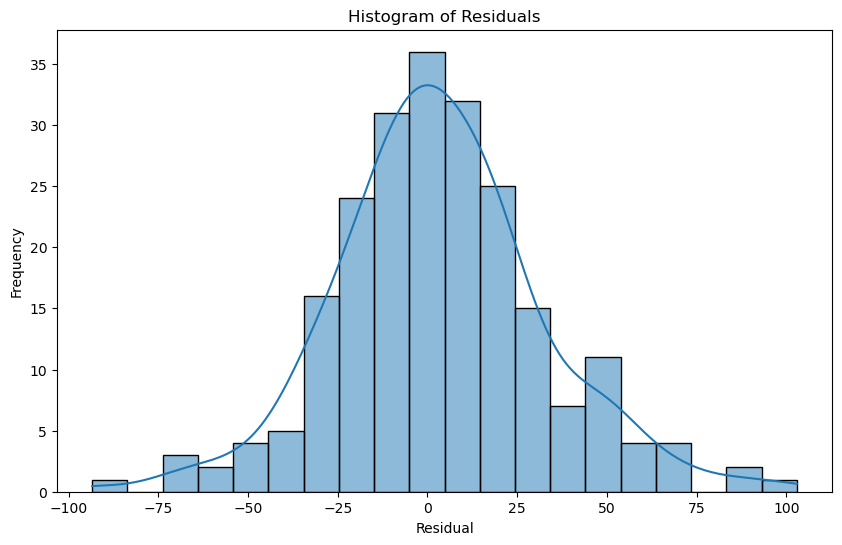

In [51]:
plt.figure(figsize=(10, 6))
sns.histplot(residuals, bins=20, edgecolor='k',kde=True)
plt.title('Histogram of Residuals')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.show()


- **Autocorrelation**

<Figure size 1000x600 with 0 Axes>

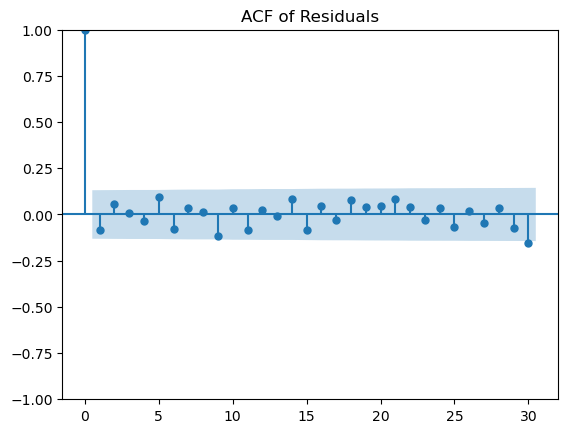

In [53]:
# ACF plot of residuals
plt.figure(figsize=(10, 6))
plot_acf(residuals, lags=30)
plt.title('ACF of Residuals')
plt.show()

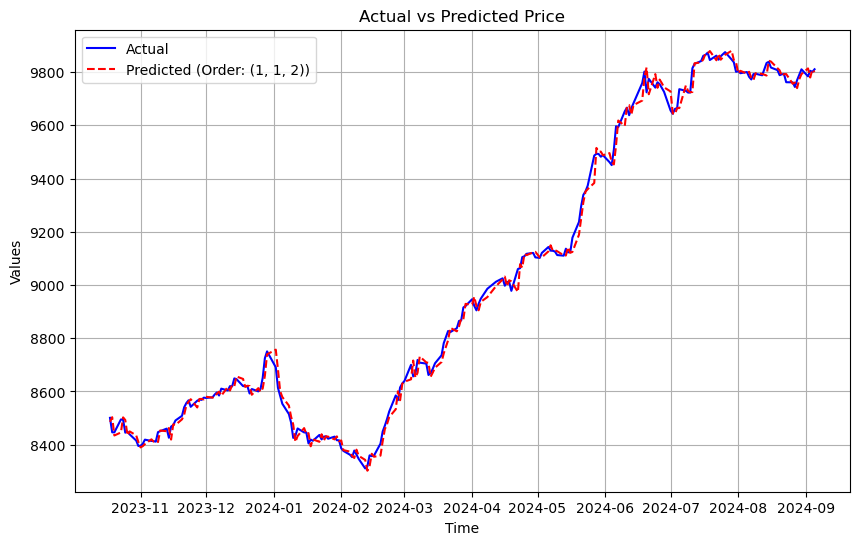

In [54]:
# Plot the actual vs predicted values for the best model based on MSE
plt.figure(figsize=(10, 6))
plt.plot(actual.index, actual, label='Actual', color='blue')

# Plot the predicted values
plt.plot(predictions, label=f'Predicted (Order: {best_order})', color='red',linestyle='--')
plt.title('Actual vs Predicted Price')
plt.xlabel('Time')
plt.ylabel('Values')
plt.legend()
plt.grid(True)
plt.show()


In [59]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1113
Model:                 ARIMA(1, 1, 2)   Log Likelihood               -5275.253
Date:                Fri, 06 Sep 2024   AIC                          10558.505
Time:                        14:09:30   BIC                          10578.561
Sample:                             0   HQIC                         10566.089
                               - 1113                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9485      0.032     29.973      0.000       0.887       1.011
ma.L1         -0.7675      0.040    -19.250      0.000      -0.846      -0.689
ma.L2         -0.1300      0.027     -4.741      0.000      -0.184      -0.076
sigma2       772.5781     23.720     32.571      0.000     726.088     819.069
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               230.15
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               1.05   Skew:                             0.03
Prob(H) (two-sided):                  0.61   Kurtosis:                         5.23
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# Conclusion 
everything is fine with the model and the assumptions are met 